In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')



In [11]:
all_data_df = pd.read_csv("./Data/Data.csv")
ss = pd.read_csv("SampleSubmission.csv")

In [12]:
### CHANGE NAME OF FOLDER AND FILES TO CORRESPOND ####
climate_data=pd.read_excel("./ClimateData/Climate Data/Kalam Climate Data.xlsx")
climate_data.head

<bound method NDFrame.head of                 Date Time  Temperature (°C)  Dewpoint Temperature (°C)  \
0     2023-06-03 13:00:00          7.199731                  -2.448126   
1     2023-06-03 14:00:00          6.000620                  -2.597540   
2     2023-06-03 15:00:00          4.789972                  -2.696951   
3     2023-06-03 16:00:00          3.158746                  -2.879324   
4     2023-06-03 17:00:00          1.671426                  -3.255606   
...                   ...               ...                        ...   
12223 2024-10-24 20:00:00         -5.387305                  -5.942435   
12224 2024-10-24 21:00:00         -6.008307                  -6.837256   
12225 2024-10-24 22:00:00         -6.535742                  -7.863989   
12226 2024-10-24 23:00:00         -6.864859                  -8.328970   
12227 2024-10-25 00:00:00         -7.224661                  -8.735220   

       U Wind Component (m/s)  V Wind Component (m/s)  \
0                   -0.0

In [13]:
# Count the number of missing values per feature
missing_values = climate_data.isnull().sum()

# Display columns with missing values and their count
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [14]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame (optional)
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1


In [15]:
# for all_data["Source"] aggregate by sum on day

import pandas as pd
# Assuming 'all_data_df' is already defined as in your previous code.
# Convert 'Datetime' column to datetime objects if it's not already
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

# Extract the date part
all_data_df['Date'] = all_data_df['date_time'].dt.date

# Group by 'Source' and 'Date', then sum the 'Load' for each group
aggregated_data = all_data_df.groupby(['Source', 'Date'])['kwh'].sum().reset_index()

# Display the aggregated data
aggregated_data.head()


,Source,Date,kwh
0,consumer_device_10_data_user_1,2024-07-22,0.024330
1,consumer_device_10_data_user_1,2024-07-23,0.103560
2,consumer_device_10_data_user_1,2024-07-24,0.137543
3,consumer_device_10_data_user_1,2024-07-25,0.121011
4,consumer_device_10_data_user_1,2024-07-26,0.000000


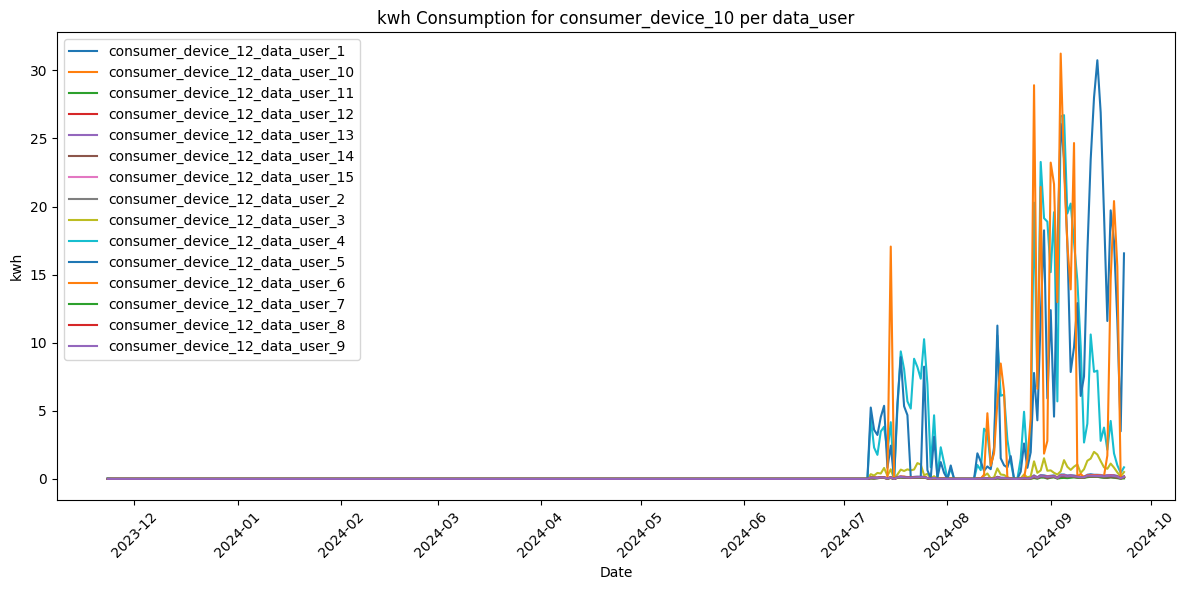

In [16]:
# Filter data for consumer_device_10
consumer_10_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_12')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# Find the minimum and maximum date_time values
min_date = aggregated_data['Date'].min()
max_date = aggregated_data['Date'].max()

print(f"Minimum date_time: {min_date}")
print(f"Maximum date_time: {max_date}")

Minimum date_time: 2023-06-03
Maximum date_time: 2024-09-23


In [18]:
# Fill missing date values with 0 kwh

# Create a date range
date_rng = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the complete data
complete_data = pd.DataFrame()

# Iterate through each unique 'Source'
for source in aggregated_data['Source'].unique():
    # Extract data for the current 'Source'
    source_data = aggregated_data[aggregated_data['Source'] == source].copy()

    # Convert the source data Date to match the type of date_rng
    source_data['Date'] = pd.to_datetime(source_data['Date'])

    # Create a complete date range for the current 'Source'
    source_date_rng = pd.DataFrame({'Date': date_rng})
    source_date_rng['Source'] = source

    # Merge with the existing data, filling missing 'kwh' values with 0
    source_data = pd.merge(source_date_rng, source_data, on=['Date', 'Source'], how='left')
    # source_data['kwh'] = source_data['kwh'].fillna(0)
    source_data = source_data.dropna()
    # Append to the complete data
    complete_data = pd.concat([complete_data, source_data], ignore_index=True)

In [19]:
### CHANGE NAME OF FOLDER AND FILES TO CORRESPOND ####
climate_df = pd.read_excel("./ClimateData/Climate Data/Kalam Climate Data.xlsx")# Convert to datetime
complete_data["Date"] = pd.to_datetime(complete_data["Date"])
climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])

# Aggregate climate data to daily level
climate_daily = climate_df.groupby(climate_df["Date Time"].dt.date).agg({
    "Temperature (°C)": "mean",
    "Dewpoint Temperature (°C)": "mean",
    "U Wind Component (m/s)": "mean",
    "V Wind Component (m/s)": "mean",
    "Total Precipitation (mm)": "sum",
    "Snowfall (mm)": "sum",
    "Snow Cover (%)": "mean",
}).reset_index()

# Convert 'Date' column in climate_daily to datetime format
climate_daily.rename(columns={"Date Time": "Date"}, inplace=True)
climate_daily["Date"] = pd.to_datetime(climate_daily["Date"])  # Ensure datetime64[ns]

# Merge with complete_data
complete_data = complete_data.merge(climate_daily, on="Date", how="left")

In [20]:
days = max_date - min_date

Consumer_device_9 could be dropped unuseful

In [21]:
# Extract consumer device and data user using regex
complete_data["consumer_device"] = complete_data["Source"].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
complete_data["data_user"] = complete_data["Source"].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)

In [22]:
# Step 1: Group by 'Source' and calculate the average of non-zero values for each feature
def fill_na_with_avg(group):
    # Calculate the average of non-zero values for each feature
    avg_v_red = group['v_red'][group['v_red'] > 0].mean() if (group['v_red'] > 0).any() else 0  # Default to 0 if no non-zero values
    avg_v_blue = group['v_blue'][group['v_blue'] > 0].mean() if (group['v_blue'] > 0).any() else 0  # Default to 0 if no non-zero values
    avg_v_yellow = group['v_yellow'][group['v_yellow'] > 0].mean() if (group['v_yellow'] > 0).any() else 0  # Default to 0 if no non-zero values

    # Fill NaN values with the calculated averages (keeping non-zero values as is)
    group['v_red'] = group['v_red'].fillna(avg_v_red)
    group['v_blue'] = group['v_blue'].fillna(avg_v_blue)
    group['v_yellow'] = group['v_yellow'].fillna(avg_v_yellow)
    
    return group


In [23]:
import pandas as pd
import numpy as np

# Convert 'Date' to datetime format if not already
complete_data["Date"] = pd.to_datetime(complete_data["Date"])

# Extract date features (keeping only useful ones)
complete_data["year"] = complete_data["Date"].dt.year
complete_data["day"] = complete_data["Date"].dt.day
complete_data["is_weekend"] = (complete_data["Date"].dt.dayofweek >= 5).astype(int)  # 1 if Sat/Sun, else 0

# Sinusoidal encoding of cyclical features
complete_data["day_of_week_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.dayofweek / 7)
complete_data["day_of_week_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.dayofweek / 7)

complete_data["month_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.month / 12)
complete_data["month_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.month / 12)

complete_data["week_of_year_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.isocalendar().week / 52)
complete_data["week_of_year_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.isocalendar().week / 52)

complete_data["quarter_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.quarter / 4)
complete_data["quarter_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.quarter / 4)



In [24]:
complete_data

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),...,day,is_weekend,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos
0,2024-07-22,consumer_device_10_data_user_1,0.024330,14.719596,8.280669,0.022655,-0.104998,0.073049,0.000000,0.000000,...,22,0,0.000000,1.000000,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
1,2024-07-23,consumer_device_10_data_user_1,0.103560,13.217268,9.862700,0.116137,-0.077997,0.121921,0.000000,0.000000,...,23,0,0.781831,0.623490,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
2,2024-07-24,consumer_device_10_data_user_1,0.137543,12.462190,9.865658,0.103451,-0.075028,0.119984,0.000000,0.000000,...,24,0,0.974928,-0.222521,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
3,2024-07-25,consumer_device_10_data_user_1,0.121011,13.867551,8.973798,0.066345,-0.043182,0.034283,0.000000,0.000000,...,25,0,0.433884,-0.900969,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
4,2024-07-26,consumer_device_10_data_user_1,0.000000,15.572609,9.434734,0.093025,0.046414,0.006961,0.000000,0.000000,...,26,0,-0.433884,-0.900969,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136404,2024-09-10,consumer_device_9_data_user_9,0.000000,8.972100,4.735042,0.100475,0.099872,0.012961,0.000000,0.000000,...,10,0,0.781831,0.623490,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136405,2024-09-11,consumer_device_9_data_user_9,0.000000,9.216674,2.945390,0.031060,-0.080538,0.014010,0.000000,0.000000,...,11,0,0.974928,-0.222521,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136406,2024-09-12,consumer_device_9_data_user_9,0.000000,10.711587,1.898337,-0.069007,-0.089148,0.002685,0.000000,0.000000,...,12,0,0.433884,-0.900969,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136407,2024-09-13,consumer_device_9_data_user_9,0.000000,10.078417,3.285115,0.170258,0.271345,0.009149,0.000000,0.000000,...,13,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16


In [25]:
complete_data.columns

Index(['Date', 'Source', 'kwh', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'consumer_device', 'data_user', 'year', 'day',
       'is_weekend', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

# CLEANING

In [26]:
# These are the devices that are not in the test SampleSubmission

devices_to_drop = ["consumer_device_3","consumer_device_5","consumer_device_11", "consumer_device_14",
                   "consumer_device_15", "consumer_device_17", "consumer_device_24",
                   "consumer_device_25","consumer_device_27","consumer_device_33","consumer_device_4","consumer_device_9"]

In [22]:
filtered_df = complete_data[complete_data['Source'].str.startswith(tuple(devices_to_drop))]
filtered_df.head()


,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),...,day,is_weekend,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos
1152,2023-10-01,consumer_device_11_data_user_1,1.739986,-0.356678,-8.421920,0.064102,-0.773024,0.001031,0.000268,71.363607,...,1,1,-0.781831,0.623490,-0.866025,0.5,-1.0,-0.0,-2.449294e-16,1.0
1153,2023-10-02,consumer_device_11_data_user_1,3.745510,0.640565,-4.417801,0.201683,-0.425513,0.012289,0.001962,47.134440,...,2,0,0.000000,1.000000,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0
1154,2023-10-03,consumer_device_11_data_user_1,3.846065,1.269988,-4.233044,-0.020184,-0.633934,0.006746,0.000190,27.332601,...,3,0,0.781831,0.623490,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0
1155,2023-10-04,consumer_device_11_data_user_1,2.494146,3.635788,-5.681771,-0.068363,-0.678879,0.000507,0.000004,14.637614,...,4,0,0.974928,-0.222521,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0
1156,2023-10-05,consumer_device_11_data_user_1,2.106918,4.786071,-4.828240,-0.234774,-0.672235,0.000017,0.000000,7.346029,...,5,0,0.433884,-0.900969,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0


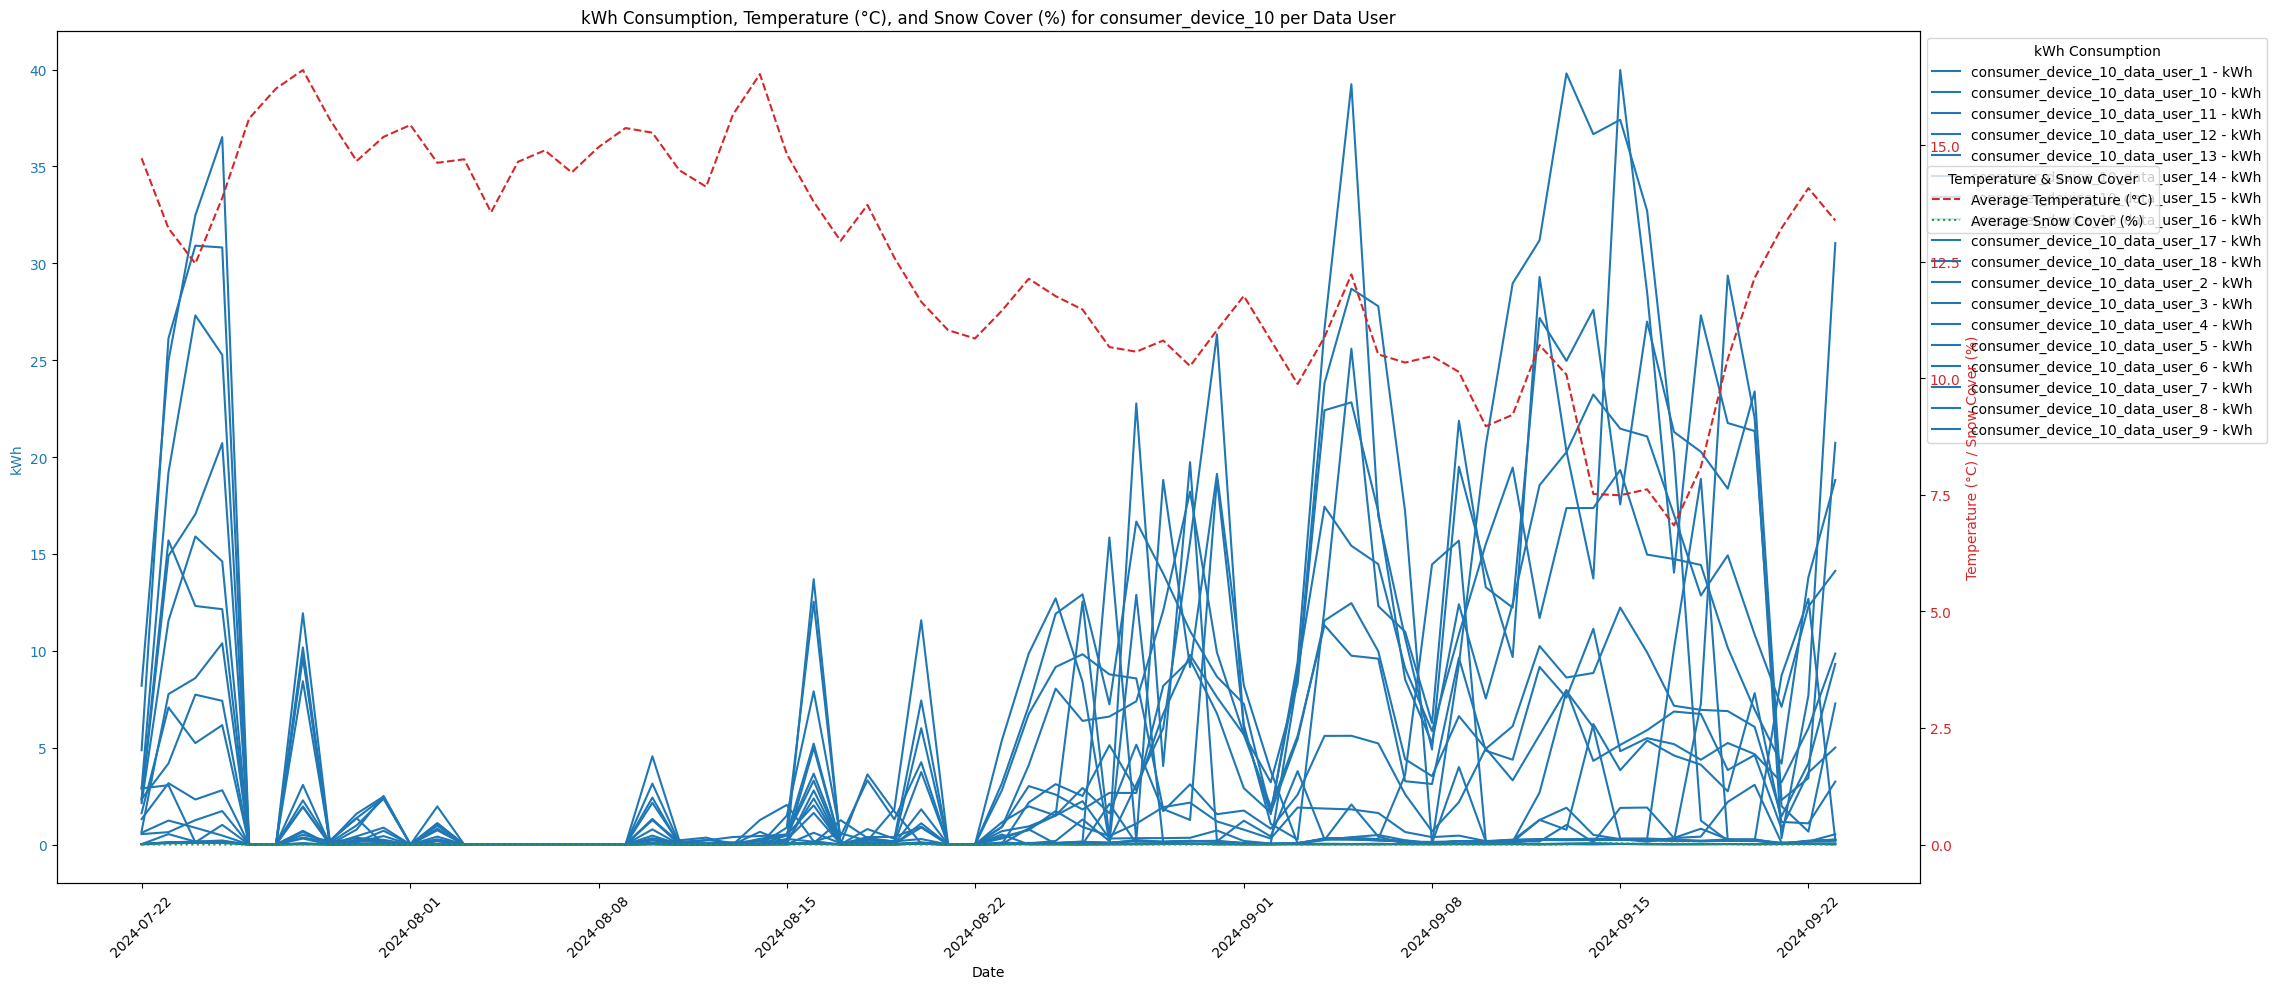

In [23]:
import matplotlib.pyplot as plt

 # Filter data for consumer_device_10
consumer_10_data = complete_data[complete_data['Source'].str.contains('consumer_device_10')]# Create the plot
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot kWh data
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    ax1.plot(user_data['Date'], user_data['kwh'], label=f'{data_user} - kWh', color='tab:blue')

# Set up the first axis for kWh
ax1.set_xlabel('Date')
ax1.set_ylabel('kWh', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for temperature and snow cover
ax2 = ax1.twinx()

# Plot Temperature and Snow Cover data (only once for each date)
ax2.plot(consumer_10_data['Date'].unique(), 
         consumer_10_data.groupby('Date')['Temperature (°C)'].mean(), 
         label='Average Temperature (°C)', linestyle='--', color='tab:red')

ax2.plot(consumer_10_data['Date'].unique(), 
         consumer_10_data.groupby('Date')['Snow Cover (%)'].mean(), 
         label='Average Snow Cover (%)', linestyle=':', color='tab:green')

# Set up the second axis for temperature and snow cover
ax2.set_ylabel('Temperature (°C) / Snow Cover (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set plot title and adjust layout for better fit
plt.title('kWh Consumption, Temperature (°C), and Snow Cover (%) for consumer_device_10 per Data User')
fig.tight_layout()

# Add legends (combining all labels)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="kWh Consumption")
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.85), title="Temperature & Snow Cover")

# Show the plot
plt.show()


In [9]:
def check_save_pred(forecast_pred, data, sss, file_name="forecast.csv"):
    print(forecast_pred.head())
    forecast_pred["kwh"] = forecast_pred["kwh"].fillna(0)
    # prompt: list the difference in the ID between forecast and ss
    print(len(data), len(forecast_pred), len(sss))
    # Assuming 'forecast' and 'ss' DataFrames are already defined as in your provided code.
    forecast_pred.to_csv(file_name, index = False)
    # Convert 'ID' columns to sets for efficient comparison
    forecast_ids = set(forecast_pred['ID'])
    ss_ids = set(sss['ID'])
    
    # Find IDs present in forecast but not in ss
    forecast_only_ids = forecast_ids - ss_ids
    
    # Find IDs present in ss but not in forecast
    ss_only_ids = ss_ids - forecast_ids
    
    # Print the IDs that are in forecast but not in ss
    print("IDs in 'forecast' but not in 'ss':")
    print(forecast_only_ids)
    
    
    # Print the IDs that are in ss but not in forecast
    print("\nIDs in 'ss' but not in 'forecast':")
    print(ss_only_ids)
    
    # Print the number of IDs that differ
    print(f"\nNumber of IDs that differ: {len(forecast_only_ids) + len(ss_only_ids)}")

In [40]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Function to process and forecast per unique consumer_device_x and data_user_y
def forecast_arima(all_data, forecast_horizon=30, output_template=None):
    # Store forecasts
    forecast_results = []

    # Process each unique consumer_device_x and data_user_y combination
    for (consumer_device, data_user), group in all_data.groupby(["consumer_device", "data_user"]):
        # Set Date as index
        group = group.set_index("Date")

        # Ensure data is in the correct format
        group = group.asfreq('D').fillna(method='ffill')  # Fill missing dates with last known value

        # Fit ARIMA model
        try:
            model = ARIMA(group["kwh"], order=(7, 1, 3))  # ARIMA(5,1,0) as a baseline
            fitted_model = model.fit()

            # Forecast for the next forecast_horizon days
            forecast_dates = pd.date_range(start=group.index[-1] + pd.Timedelta(days=1),
                                           periods=forecast_horizon, freq='D')
            forecast_values = fitted_model.forecast(steps=forecast_horizon)

            # Store results in required format
            forecast_df = pd.DataFrame({
                "ID": [f"{date.strftime('%Y-%m-%d')}_consumer_device_{consumer_device}_data_user_{data_user}"
                        for date in forecast_dates],
                "kwh": forecast_values
            })

            forecast_results.append(forecast_df)

        except Exception as e:
            print(f"Error processing {consumer_device}_{data_user}: {e}")

    # Combine all forecasts into a single DataFrame
    forecast_df = pd.concat(forecast_results, ignore_index=True)

    # If an output template is provided, align the output format
    if output_template is not None:
        output_template = output_template.drop(columns=['kwh'], errors='ignore')
        final_output = output_template.merge(forecast_df, on='ID', how='left').fillna(0)
    else:
        final_output = forecast_df

    return final_output


In [26]:
forecast_arima = forecast_arima(all_data=complete_data, forecast_horizon=30, output_template=ss)

In [34]:
forecast_arima

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.165630
1,2024-09-25_consumer_device_12_data_user_1,0.159924
2,2024-09-26_consumer_device_12_data_user_1,0.205964
3,2024-09-27_consumer_device_12_data_user_1,0.185630
4,2024-09-28_consumer_device_12_data_user_1,0.160174
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.268298
6010,2024-10-21_consumer_device_8_data_user_9,0.268629
6011,2024-10-22_consumer_device_8_data_user_9,0.267906
6012,2024-10-23_consumer_device_8_data_user_9,0.268044


In [27]:
forecast_arima=(forecast_arima.copy())
forecast_arima.loc[forecast_arima['kwh'] < 0, 'kwh'] = 0

In [28]:
 check_save_pred(forecast_pred=forecast_arima, data=complete_data, sss=ss, file_name="forecast_arima.csv")

                                          ID       kwh
0  2024-09-24_consumer_device_12_data_user_1  0.165220
1  2024-09-25_consumer_device_12_data_user_1  0.158772
2  2024-09-26_consumer_device_12_data_user_1  0.205351
3  2024-09-27_consumer_device_12_data_user_1  0.185120
4  2024-09-28_consumer_device_12_data_user_1  0.159856
136409 6014 6014
IDs in 'forecast' but not in 'ss':
set()

IDs in 'ss' but not in 'forecast':
set()

Number of IDs that differ: 0


In [29]:
X = complete_data.drop(columns=['Date','Source', 'kwh'])
y = complete_data.kwh
X.fillna(-1,inplace=True)
from sklearn.model_selection import *
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    shuffle=True, stratify=X['consumer_device'])
from catboost import *
model_cat = CatBoostRegressor(iterations=12000, loss_function='RMSE', use_best_model=True,
                          early_stopping_rounds=100, verbose=100, random_state=42,
                          )
model_cat.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.023129
0:	learn: 3.7152810	test: 3.8320460	best: 3.8320460 (0)	total: 118ms	remaining: 23m 32s
100:	learn: 3.1513266	test: 3.3294533	best: 3.3294533 (100)	total: 1.02s	remaining: 1m 59s
200:	learn: 2.8826772	test: 3.0544146	best: 3.0544146 (200)	total: 1.83s	remaining: 1m 47s
300:	learn: 2.7257418	test: 2.8867842	best: 2.8867842 (300)	total: 2.6s	remaining: 1m 41s
400:	learn: 2.6216137	test: 2.7777265	best: 2.7777265 (400)	total: 3.4s	remaining: 1m 38s
500:	learn: 2.5377569	test: 2.6900656	best: 2.6900656 (500)	total: 4.16s	remaining: 1m 35s
600:	learn: 2.4574617	test: 2.6050082	best: 2.6050082 (600)	total: 4.92s	remaining: 1m 33s
700:	learn: 2.3954892	test: 2.5336694	best: 2.5336694 (700)	total: 5.69s	remaining: 1m 31s
800:	learn: 2.3404594	test: 2.4702360	best: 2.4702360 (800)	total: 6.46s	remaining: 1m 30s
900:	learn: 2.2992633	test: 2.4255311	best: 2.4255311 (900)	total: 7.22s	remaining: 1m 28s
1000:	learn: 2.2652966	test: 2.3925215	best: 2.3925215 (1000)	tot

In [57]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Function to process and forecast per unique consumer_device_x and data_user_y
def forecast_arima_test(all_data, forecast_horizon=25):
    # Store forecasts
    forecast_results = []

    # Process each unique consumer_device_x and data_user_y combination
    for (consumer_device, data_user), group in all_data.groupby(["consumer_device", "data_user"]):
        # Set Date as index
        group = group.set_index("Date")

        # Ensure data is in the correct format
        group = group.asfreq('D').fillna(method='ffill')  # Fill missing dates with last known value

        # Fit ARIMA model
        try:
            model = ARIMA(group["kwh"], order=(7, 1, 3))  # ARIMA(7,1,3) as a baseline
            fitted_model = model.fit()

            # Forecast for the next forecast_horizon days
            forecast_dates = pd.date_range(start=group.index[-1] + pd.Timedelta(days=1),
                                           periods=forecast_horizon, freq='D')
            forecast_values = fitted_model.forecast(steps=forecast_horizon)

            # Store results in required format
            forecast_df = pd.DataFrame({
                "consumer_device": [consumer_device] * forecast_horizon,
                "data_user": [data_user] * forecast_horizon,
                "Date": forecast_dates,
                "kwh": forecast_values
            })

            forecast_results.append(forecast_df)

        except Exception as e:
            print(f"Error processing {consumer_device}_{data_user}: {e}")

    # Combine all forecasts into a single DataFrame
    forecast_df = pd.concat(forecast_results, ignore_index=True)

    return forecast_df


In [34]:
# CODE POUR TEST PART PAST DAYS
last_30_days = complete_data["Date"].max() - pd.Timedelta(days=25)  # Get the start date of the last 20 days

X_train_all= complete_data[complete_data["Date"] < last_30_days]
X_test_all= complete_data[complete_data["Date"]  >= last_30_days]

X = complete_data.drop(columns=['Source', 'kwh'])
y = complete_data.kwh
# Ensure 'Date' is in datetime format
X["Date"] = pd.to_datetime(X["Date"])



# Split data based on date
X_train = X[X["Date"] < last_30_days]
X_test = X[X["Date"] >= last_30_days]

y_train = y.loc[X_train.index]  # Keep only corresponding indices
y_test = y.loc[X_test.index]
X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])


# Display split sizes
#print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
X_test.head

<bound method NDFrame.head of         Temperature (°C)  Dewpoint Temperature (°C)  U Wind Component (m/s)  \
38             10.809994                   8.364133               -0.080489   
39             10.262593                   7.525781               -0.458007   
40             11.031700                   8.413293               -0.071244   
41             11.767033                   9.057457                0.045252   
42             10.818548                   8.942941                0.153840   
...                  ...                        ...                     ...   
136404          8.972100                   4.735042                0.100475   
136405          9.216674                   2.945390                0.031060   
136406         10.711587                   1.898337               -0.069007   
136407         10.078417                   3.285115                0.170258   
136408          7.519299                   5.544675               -0.116898   

        V Wind Compon

In [44]:
last_30_days = complete_data["Date"].max() - pd.Timedelta(days=25)  # Get the start date of the last 20 days
last_30_days

Timestamp('2024-08-29 00:00:00')

In [36]:
X_train_all.columns

Index(['Date', 'Source', 'kwh', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'consumer_device', 'data_user', 'year', 'day',
       'is_weekend', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

In [37]:
complete_data.columns

Index(['Date', 'Source', 'kwh', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'consumer_device', 'data_user', 'year', 'day',
       'is_weekend', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

In [58]:
forecast_arima_25last = forecast_arima_test(all_data=X_train_all, forecast_horizon=25)

In [59]:
forecast_arima_25last

,consumer_device,data_user,Date,kwh
0,1,1,2023-11-21,0.116614
1,1,1,2023-11-22,0.203476
2,1,1,2023-11-23,0.141560
3,1,1,2023-11-24,0.225267
4,1,1,2023-11-25,0.168894
...,...,...,...,...
14620,39,15,2024-01-13,0.013555
14621,39,15,2024-01-14,0.013501
14622,39,15,2024-01-15,0.013449
14623,39,15,2024-01-16,0.013451


In [71]:
X_test_all= complete_data[complete_data["Date"]  >= last_30_days]
X_test_all.columns
X_test_all.rename(columns={'kwh': 'kwh_actual'}, inplace=True)


In [72]:
import pandas as pd

# Feature engineering on forecast dates
forecast_arima_25last['Date'] = pd.to_datetime(forecast_arima_25last['Date'])

forecast_arima_25last['year'] = forecast_arima_25last['Date'].dt.year
forecast_arima_25last['day'] = forecast_arima_25last['Date'].dt.day

forecast_arima_25last["month_sin"] = np.sin(2 * np.pi * forecast_arima_25last["Date"].dt.month / 12)
forecast_arima_25last["month_cos"] = np.cos(2 * np.pi * forecast_arima_25last["Date"].dt.month / 12)

print(forecast_arima_25last)
# Merge based on the common features
X_test_with_arima = X_test_all.copy()

X_test_with_arima = X_test_with_arima.merge(
    forecast_arima_25last[['year', 'day', 'month_sin', 'month_cos', 'consumer_device', 'data_user', 'kwh']],
    on=['year', 'day', 'month_sin', 'month_cos', 'consumer_device', 'data_user'],
    how='left'
)

# Rename column for clarity
X_test_with_arima.rename(columns={'kwh': 'kwh_arima'}, inplace=True)



       consumer_device  data_user       Date       kwh  year  day  month_sin  \
0                    1          1 2023-11-21  0.116614  2023   21       -0.5   
1                    1          1 2023-11-22  0.203476  2023   22       -0.5   
2                    1          1 2023-11-23  0.141560  2023   23       -0.5   
3                    1          1 2023-11-24  0.225267  2023   24       -0.5   
4                    1          1 2023-11-25  0.168894  2023   25       -0.5   
...                ...        ...        ...       ...   ...  ...        ...   
14620               39         15 2024-01-13  0.013555  2024   13        0.5   
14621               39         15 2024-01-14  0.013501  2024   14        0.5   
14622               39         15 2024-01-15  0.013449  2024   15        0.5   
14623               39         15 2024-01-16  0.013451  2024   16        0.5   
14624               39         15 2024-01-17  0.013517  2024   17        0.5   

       month_cos  
0       0.866025  
1

In [73]:
X_test_with_arima.columns

Index(['Date', 'Source', 'kwh_actual', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'consumer_device', 'data_user', 'year', 'day',
       'is_weekend', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin',
       'quarter_cos', 'kwh_arima'],
      dtype='object')

In [74]:
X_test_with_arima['kwh_arima'].isnull().sum()


347

In [77]:
X_test_cat=X_test_with_arima.drop(columns=['kwh_arima', 'kwh_actual', 'Source'])
forecast_cat_25last=model_cat.predict(X_test_cat)
X_test_with_arima['kwh_cat'] = forecast_cat_25last

In [78]:
forecast_cat_25last

array([10.70677136,  5.64905521, 11.23044004, ..., -0.65905861,
       -0.06888986, -0.58369188])

In [82]:
X_test_with_arima.fillna(0)


,Date,Source,kwh_actual,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),...,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,kwh_arima,kwh_cat,kwh_combined
0,2024-08-29,consumer_device_10_data_user_1,18.816897,10.809994,8.364133,-0.080489,0.244804,0.051317,0.000000,0.000000,...,-0.900969,-0.866025,-5.000000e-01,-0.885456,-0.464723,-1.0,-1.836970e-16,-3.781361,10.706771,3.462705
1,2024-08-30,consumer_device_10_data_user_1,9.158320,10.262593,7.525781,-0.458007,0.040709,0.125237,0.000000,0.000000,...,-0.900969,-0.866025,-5.000000e-01,-0.885456,-0.464723,-1.0,-1.836970e-16,-1.416879,5.649055,2.116088
2,2024-08-31,consumer_device_10_data_user_1,19.128525,11.031700,8.413293,-0.071244,-0.204269,0.173941,0.000000,0.000000,...,-0.222521,-0.866025,-5.000000e-01,-0.885456,-0.464723,-1.0,-1.836970e-16,-0.545430,11.230440,5.342505
3,2024-09-01,consumer_device_10_data_user_1,8.215966,11.767033,9.057457,0.045252,-0.016033,0.115252,0.000000,0.000000,...,0.623490,-1.000000,-1.836970e-16,-0.885456,-0.464723,-1.0,-1.836970e-16,1.062990,3.646651,2.354820
4,2024-09-02,consumer_device_10_data_user_1,3.804871,10.818548,8.942941,0.153840,0.189569,0.087353,0.000000,0.000000,...,1.000000,-1.000000,-1.836970e-16,-0.935016,-0.354605,-1.0,-1.836970e-16,0.258375,3.237354,1.747864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9678,2024-09-10,consumer_device_9_data_user_9,0.000000,8.972100,4.735042,0.100475,0.099872,0.012961,0.000000,0.000000,...,0.623490,-1.000000,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16,0.000001,-1.382374,-0.691187
9679,2024-09-11,consumer_device_9_data_user_9,0.000000,9.216674,2.945390,0.031060,-0.080538,0.014010,0.000000,0.000000,...,-0.222521,-1.000000,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16,0.000001,-1.017260,-0.508629
9680,2024-09-12,consumer_device_9_data_user_9,0.000000,10.711587,1.898337,-0.069007,-0.089148,0.002685,0.000000,0.000000,...,-0.900969,-1.000000,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16,0.000001,-0.659059,-0.329529
9681,2024-09-13,consumer_device_9_data_user_9,0.000000,10.078417,3.285115,0.170258,0.271345,0.009149,0.000000,0.000000,...,-0.900969,-1.000000,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16,0.000001,-0.068890,-0.034444


In [117]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Prepare the feature matrix using only 'kwh_cat' and 'kwh_arima'
X = X_test_with_arima[['kwh_cat', 'kwh_arima']]  # Only these two features
y = X_test_with_arima['kwh_actual']  # The target variable

# Check for missing values
if X.isnull().any().any() or y.isnull().any():
    print("Missing values detected. Handling missing values...")
    X = X.dropna()
    y = y[X.index]

# Fit the model to the data
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X, y)

# Predict using the fitted model
y_pred_tree = tree_model.predict(X)

# Calculate RMSE
rmse_tree = mean_squared_error(y, y_pred_tree)
print(f"RMSE of the Decision Tree model: {rmse_tree}")

# Add predictions to the original DataFrame
X_test_with_arima['kwh_predicted_tree'] = None
X_test_with_arima.loc[X.index, 'kwh_predicted_tree'] = y_pred_tree


Missing values detected. Handling missing values...
RMSE of the Decision Tree model: 0.0


In [139]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Prepare the feature matrix using only 'kwh_cat' and 'kwh_arima'
X = X_test_with_arima[['kwh_cat', 'kwh_arima']]  # Only these two features
y = X_test_with_arima['kwh_actual']  # The target variable

# Check for missing values
if X.isnull().any().any() or y.isnull().any():
    print("Missing values detected. Handling missing values...")
    X = X.dropna()
    y = y[X.index]

# Fit the model to the data
lasso_model = Lasso(alpha=0.1)  # alpha controls the regularization strength
lasso_model.fit(X, y)

# Predict using the fitted model
y_pred_lasso = lasso_model.predict(X)

# Calculate RMSE
rmse_lasso = mean_squared_error(y, y_pred_lasso)
print(f"RMSE of the Lasso regression model: {rmse_lasso}")

# Add predictions to the original DataFrame
X_test_with_arima['kwh_predicted_lasso'] = None
X_test_with_arima.loc[X.index, 'kwh_predicted_lasso'] = y_pred_lasso


Missing values detected. Handling missing values...
RMSE of the Lasso regression model: 10.970433802736972


In [105]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Prepare the feature matrix using only 'kwh_cat' and 'kwh_arima'
X = X_test_with_arima[['kwh_cat', 'kwh_arima']]  # Only these two features
y = X_test_with_arima['kwh_actual']  # The target variable

# Check for missing values
if X.isnull().any().any() or y.isnull().any():
    print("Missing values detected. Handling missing values...")
    X = X.dropna()
    y = y[X.index]

# Fit the model to the data
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X, y)

# Predict using the fitted model
y_pred_gb = gb_model.predict(X)

# Calculate RMSE
rmse_gb = mean_squared_error(y, y_pred_gb)
print(f"RMSE of the Gradient Boosting model: {rmse_gb}")

# Add predictions to the original DataFrame
X_test_with_arima['kwh_predicted_gb'] = None
X_test_with_arima.loc[X.index, 'kwh_predicted_gb'] = y_pred_gb


Missing values detected. Handling missing values...
RMSE of the Gradient Boosting model: 6.9119386612249185


In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare the feature matrix using only 'kwh_cat' and 'kwh_arima'
X = X_test_with_arima[['kwh_cat', 'kwh_arima']]  # Only these two features
y = X_test_with_arima['kwh_actual']  # The target variable

# Check for missing values
if X.isnull().any().any() or y.isnull().any():
    print("Missing values detected. Handling missing values...")
    X = X.dropna()
    y = y[X.index]

# Fit the model to the data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Predict using the fitted model
y_pred_rf = rf_model.predict(X)

# Calculate RMSE
rmse_rf = mean_squared_error(y, y_pred_rf)
print(f"RMSE of the Random Forest model: {rmse_rf}")

# Add predictions to the original DataFrame
X_test_with_arima['kwh_predicted_rf'] = None
X_test_with_arima.loc[X.index, 'kwh_predicted_rf'] = y_pred_rf


Missing values detected. Handling missing values...
RMSE of the Random Forest model: 1.3881206963457653


In [140]:
# prompt: compute RMSE score between forecast and ss

import pandas as pd
from sklearn.metrics import mean_squared_error
import math

# Load the two CSV files
forecast_cat_best = pd.read_csv("forecast-cat_base_109.csv")
forecast_arima_best = pd.read_csv("forecast_arima.csv")

# Merge the two DataFrames on a common column (e.g., 'Date' or 'Index')
# Replace 'common_column' with the actual name of the column they share
merge_best = pd.merge(forecast_cat_best, forecast_arima_best, on='ID', how='left', suffixes=('_cat', '_arima'))

# Display the first few rows of the merged DataFrame
print(merge_best.tail(20))




                                            ID   kwh_cat  kwh_arima
5994  2024-10-05_consumer_device_8_data_user_9  0.538532   0.276666
5995  2024-10-06_consumer_device_8_data_user_9  0.677548   0.277034
5996  2024-10-07_consumer_device_8_data_user_9  0.199734   0.276271
5997  2024-10-08_consumer_device_8_data_user_9  0.337812   0.274250
5998  2024-10-09_consumer_device_8_data_user_9  0.601014   0.273537
5999  2024-10-10_consumer_device_8_data_user_9  0.520989   0.272945
6000  2024-10-11_consumer_device_8_data_user_9  0.906158   0.273093
6001  2024-10-12_consumer_device_8_data_user_9  0.695926   0.273351
6002  2024-10-13_consumer_device_8_data_user_9  0.554719   0.274279
6003  2024-10-14_consumer_device_8_data_user_9  0.530084   0.274952
6004  2024-10-15_consumer_device_8_data_user_9  0.562842   0.275346
6005  2024-10-16_consumer_device_8_data_user_9  0.615823   0.275115
6006  2024-10-17_consumer_device_8_data_user_9  0.544283   0.274741
6007  2024-10-18_consumer_device_8_data_user_9  

In [98]:
X.columns

Index(['Temperature (°C)', 'Dewpoint Temperature (°C)',
       'U Wind Component (m/s)', 'V Wind Component (m/s)',
       'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)',
       'consumer_device', 'data_user', 'year', 'day', 'is_weekend',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos',
       'kwh_arima', 'kwh_cat', 'kwh_combined'],
      dtype='object')

In [141]:
X_rf_for = merge_best[['kwh_cat', 'kwh_arima']]  # Only these two features
prediction_final= lasso_model.predict(X_rf_for)
merge_best["kwh"]=prediction_final

In [142]:
merge_best

,ID,kwh_cat,kwh_arima,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.000000,0.165220,-0.399096
1,2024-09-25_consumer_device_12_data_user_1,0.000000,0.158772,-0.399550
2,2024-09-26_consumer_device_12_data_user_1,0.000000,0.205351,-0.396272
3,2024-09-27_consumer_device_12_data_user_1,0.000000,0.185120,-0.397696
4,2024-09-28_consumer_device_12_data_user_1,0.000000,0.159856,-0.399473
...,...,...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.528374,0.273727,0.165619
6010,2024-10-21_consumer_device_8_data_user_9,0.604873,0.273867,0.246283
6011,2024-10-22_consumer_device_8_data_user_9,0.732614,0.274140,0.380983
6012,2024-10-23_consumer_device_8_data_user_9,0.554995,0.274466,0.193738


In [143]:
forecast_final= pd.read_csv("SampleSubmission.csv")

In [144]:
forecast_final['kwh'] = merge_best['kwh']

In [145]:
 len(forecast_final), len(ss)

(6014, 6014)

In [146]:
forecast_final.to_csv("CatARIMA_lasso.csv", index = False)

In [ ]:
 check_save_pred(forecast_pred=forecast_arima, data=complete_data, sss=ss, file_name="forecast_arima.csv")

In [49]:
# Split the ID into date and source
forecasrt_arima_v['date'] = forecasrt_arima_v['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecasrt_arima_v['source'] = forecasrt_arima_v['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')

In [50]:
forecasrt_arima_v

,ID,kwh,date,source
0,2024-09-24_consumer_device_12_data_user_1,0.165630,2024-09-24,consumer_device_12_data_user_1
1,2024-09-25_consumer_device_12_data_user_1,0.159924,2024-09-25,consumer_device_12_data_user_1
2,2024-09-26_consumer_device_12_data_user_1,0.205964,2024-09-26,consumer_device_12_data_user_1
3,2024-09-27_consumer_device_12_data_user_1,0.185630,2024-09-27,consumer_device_12_data_user_1
4,2024-09-28_consumer_device_12_data_user_1,0.160174,2024-09-28,consumer_device_12_data_user_1
...,...,...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.268298,2024-10-20,consumer_device_8_data_user_9
6010,2024-10-21_consumer_device_8_data_user_9,0.268629,2024-10-21,consumer_device_8_data_user_9
6011,2024-10-22_consumer_device_8_data_user_9,0.267906,2024-10-22,consumer_device_8_data_user_9
6012,2024-10-23_consumer_device_8_data_user_9,0.268044,2024-10-23,consumer_device_8_data_user_9


In [3]:
forecast_cat= pd.read_csv("forecast-cat_base_109.csv")
forecast_cat['date'] = forecast_cat['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecast_cat['source'] = forecast_cat['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')

In [4]:
forecasrt_arima_v= pd.read_csv("forecast_arima.csv")
forecasrt_arima_v['date'] = forecast_cat['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecasrt_arima_v['source'] = forecast_cat['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')

In [132]:
# First, merge both forecasts on 'ID'
combined_forecast = forecast_cat.merge(forecasrt_arima_v, on='ID', suffixes=('_cat', '_arima'))

# Extract consumer_device from the ID (if not already present)
combined_forecast['consumer_device'] = combined_forecast['ID'].str.extract(r'consumer_device_(\d+)').astype(int)
combined_forecast['source'] = combined_forecast['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
combined_forecast['kwh'] = combined_forecast.apply(
    lambda row: min(row['kwh_cat'], row['kwh_arima']),
    axis=1
)

#combined_forecast['kwh'] = combined_forecast.apply(
#    lambda row: (row['kwh_cat'] + row['kwh_arima']) / 2 
#    if 10 < row['kwh_cat'] < 20 else row['kwh_cat'],
#    axis=1
#)
#combined_forecast['kwh'] = (combined_forecast['kwh_cat'] + combined_forecast['kwh_arima']) / 2


# Keep only necessary columns
final_forecast = combined_forecast[['ID', 'kwh']]


In [6]:
# First, merge both forecasts on 'ID'
combined_forecast = forecast_cat.merge(forecasrt_arima_v, on='ID', suffixes=('_cat', '_arima'))

# Extract consumer_device and source
combined_forecast['consumer_device'] = combined_forecast['ID'].str.extract(r'consumer_device_(\d+)').astype(int)
combined_forecast['source'] = combined_forecast['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')

# Get min forecast and model source
min_forecast = combined_forecast.copy()
min_forecast['kwh'] = min_forecast[['kwh_cat', 'kwh_arima']].min(axis=1)
min_forecast['source_model'] = min_forecast.apply(
    lambda row: 'cat' if row['kwh_cat'] <= row['kwh_arima'] else 'arima',
    axis=1
)

# Get max forecast and model source
max_forecast = combined_forecast.copy()
max_forecast['kwh'] = max_forecast[['kwh_cat', 'kwh_arima']].max(axis=1)
max_forecast['source_model'] = max_forecast.apply(
    lambda row: 'cat' if row['kwh_cat'] >= row['kwh_arima'] else 'arima',
    axis=1
)

# Keep only necessary columns for final outputs
min_forecast = min_forecast[['ID', 'kwh', 'source_model']]
max_forecast = max_forecast[['ID', 'kwh', 'source_model']]


In [66]:
# Create new DataFrame based on logic: if max from 'cat' → average; else → use arima
adjusted_max_forecast = combined_forecast.copy()

adjusted_max_forecast['kwh'] = adjusted_max_forecast.apply(
    lambda row:
    (row['kwh_cat'] + row['kwh_arima']) / 2 if (row['kwh_cat'] > row['kwh_arima'] )
    else  (3*row['kwh_cat'] + 4*row['kwh_arima']) / 7 if ( row['kwh_cat'] > 17) 
    else row['kwh_cat'],
    axis=1
)


# Keep only desired columns
adjusted_max_forecast = adjusted_max_forecast[['ID', 'kwh']]


In [29]:
adjusted_max_forecast

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.000000
1,2024-09-25_consumer_device_12_data_user_1,0.000000
2,2024-09-26_consumer_device_12_data_user_1,0.000000
3,2024-09-27_consumer_device_12_data_user_1,0.000000
4,2024-09-28_consumer_device_12_data_user_1,0.000000
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.401051
6010,2024-10-21_consumer_device_8_data_user_9,0.439370
6011,2024-10-22_consumer_device_8_data_user_9,0.503377
6012,2024-10-23_consumer_device_8_data_user_9,0.414730


In [136]:
# Count in min_forecast
min_counts = min_forecast['source_model'].value_counts()
print("Minimum Forecast Source Counts:")
print(min_counts)

# Count in max_forecast
max_counts = max_forecast['source_model'].value_counts()
print("\nMaximum Forecast Source Counts:")
print(max_counts)


Minimum Forecast Source Counts:
source_model
arima    3300
cat      2714
Name: count, dtype: int64

Maximum Forecast Source Counts:
source_model
cat      3328
arima    2686
Name: count, dtype: int64


In [67]:
 check_save_pred(forecast_pred=adjusted_max_forecast, data=complete_data, sss=ss, file_name="forecast_catarimaxavg_17_5_4arima.csv")

                                          ID  kwh
0  2024-09-24_consumer_device_12_data_user_1  0.0
1  2024-09-25_consumer_device_12_data_user_1  0.0
2  2024-09-26_consumer_device_12_data_user_1  0.0
3  2024-09-27_consumer_device_12_data_user_1  0.0
4  2024-09-28_consumer_device_12_data_user_1  0.0
136409 6014 6014
IDs in 'forecast' but not in 'ss':
set()

IDs in 'ss' but not in 'forecast':
set()

Number of IDs that differ: 0


In [49]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')



In [63]:
# prompt: compute RMSE score between forecast and ss

import pandas as pd
from sklearn.metrics import mean_squared_error
import math
forecast_best= pd.read_csv("forecast-cat_base_109.csv")

# Assuming 'forecast' and 'ss' are DataFrames with a common 'ID' column and a 'kwh' column
# containing the forecast and actual values respectively.

# Merge the forecast and ss DataFrames on the 'ID' column
merged_df = pd.merge(adjusted_max_forecast, forecast_best, on='ID', how='left', suffixes=('_forecast', '_actual'))

# Calculate the RMSE
rmse = math.sqrt(mean_squared_error(merged_df['kwh_actual'], merged_df['kwh_forecast']))

print(f"RMSE: {rmse}")


RMSE: 3.6367706078740514


In [11]:
# Filter rows where kwh > 12
high_kwh_sources = forecast_cat[forecast_cat['kwh'] > 12]['source'].unique()

# Print each source
for source in high_kwh_sources:
    print(source)


consumer_device_12_data_user_4
consumer_device_12_data_user_5
consumer_device_13_data_user_4
consumer_device_13_data_user_5
consumer_device_18_data_user_10
consumer_device_18_data_user_11
consumer_device_18_data_user_12
consumer_device_18_data_user_3
consumer_device_18_data_user_4
consumer_device_18_data_user_5
consumer_device_18_data_user_6
consumer_device_18_data_user_7
consumer_device_18_data_user_8
consumer_device_18_data_user_9
consumer_device_21_data_user_10
consumer_device_21_data_user_3
consumer_device_21_data_user_5
consumer_device_23_data_user_2
consumer_device_23_data_user_4
consumer_device_29_data_user_3
consumer_device_29_data_user_4
consumer_device_29_data_user_5
consumer_device_29_data_user_7
consumer_device_29_data_user_8
consumer_device_2_data_user_1
consumer_device_2_data_user_2
consumer_device_32_data_user_19
consumer_device_32_data_user_5


In [13]:
# Filter rows where kwh > 12
l_kwh_sources = forecasrt_arima_v[forecasrt_arima_v['kwh'] > 12]['source'].unique()

# Print each source
for source in l_kwh_sources:
    print(source)


consumer_device_12_data_user_5
consumer_device_16_data_user_2
consumer_device_18_data_user_10
consumer_device_18_data_user_11
consumer_device_18_data_user_12
consumer_device_18_data_user_4
consumer_device_18_data_user_5
consumer_device_18_data_user_6
consumer_device_18_data_user_7
consumer_device_18_data_user_8
consumer_device_18_data_user_9
consumer_device_21_data_user_10
consumer_device_21_data_user_3
consumer_device_21_data_user_5
consumer_device_22_data_user_2
consumer_device_22_data_user_3
consumer_device_22_data_user_4
consumer_device_23_data_user_2
consumer_device_23_data_user_4
consumer_device_29_data_user_1
consumer_device_29_data_user_3
consumer_device_29_data_user_7
consumer_device_2_data_user_1
consumer_device_2_data_user_2
consumer_device_2_data_user_3
consumer_device_32_data_user_19
consumer_device_32_data_user_5
consumer_device_8_data_user_6


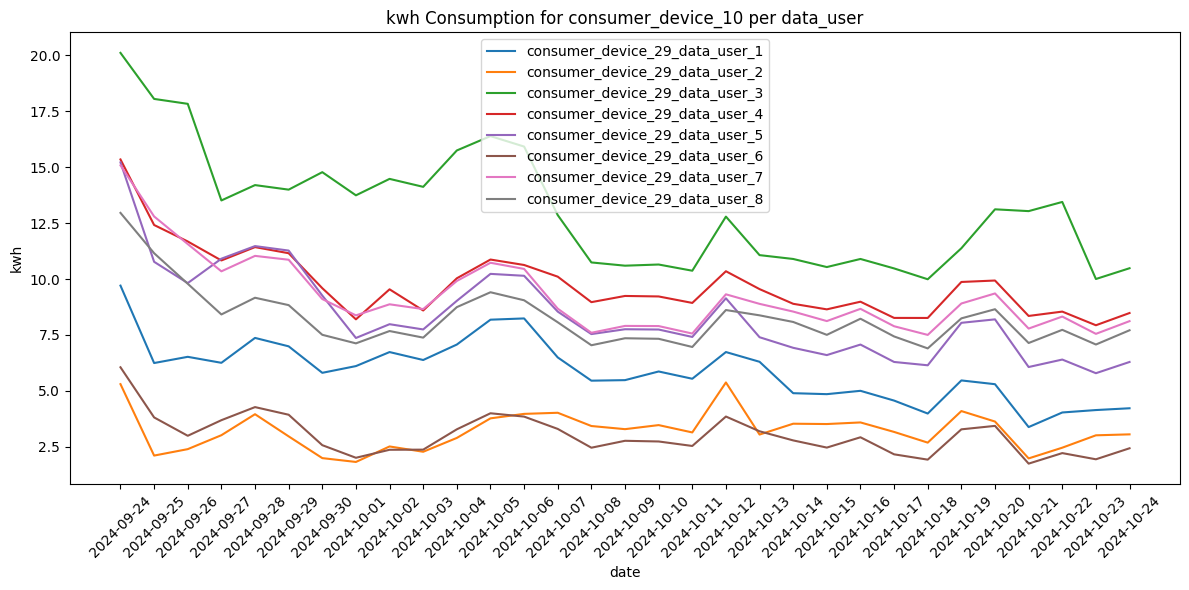

In [74]:
# Filter data for consumer_device_10
consumer_10_data = forecast_cat[forecast_cat['source'].str.contains('consumer_device_29')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_10_data['source'].unique():
    user_data = consumer_10_data[consumer_10_data['source'] == data_user]
    plt.plot(user_data['date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


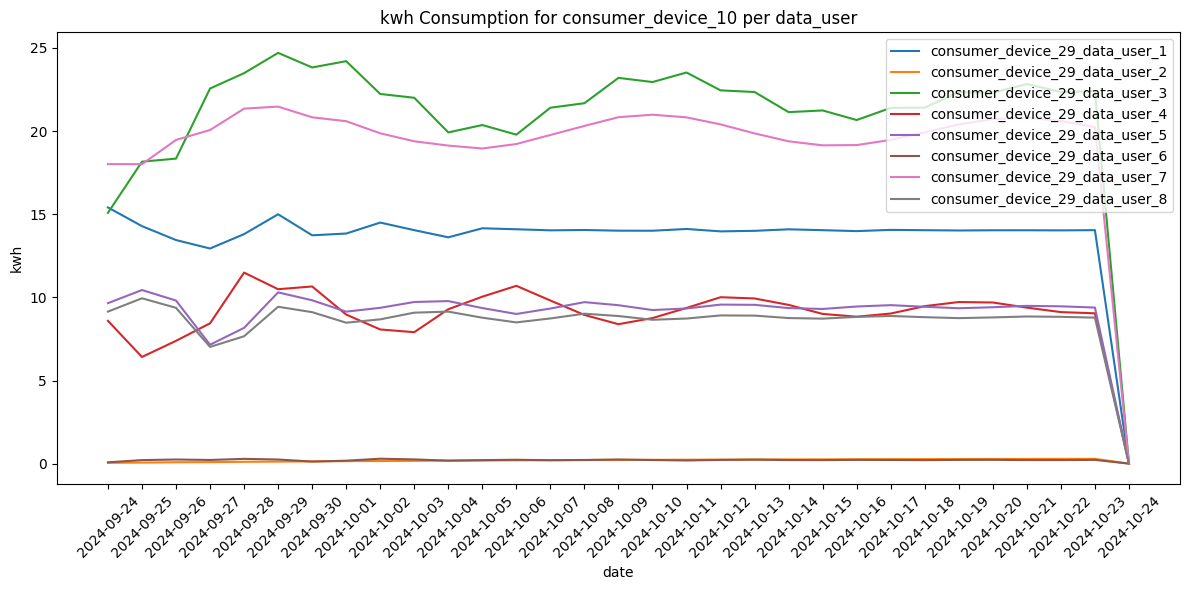

In [77]:
# Filter data for consumer_device_10
consumer_10_data = forecasrt_arima_v[forecasrt_arima_v['source'].str.contains('consumer_device_29')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_10_data['source'].unique():
    user_data = consumer_10_data[consumer_10_data['source'] == data_user]
    plt.plot(user_data['date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


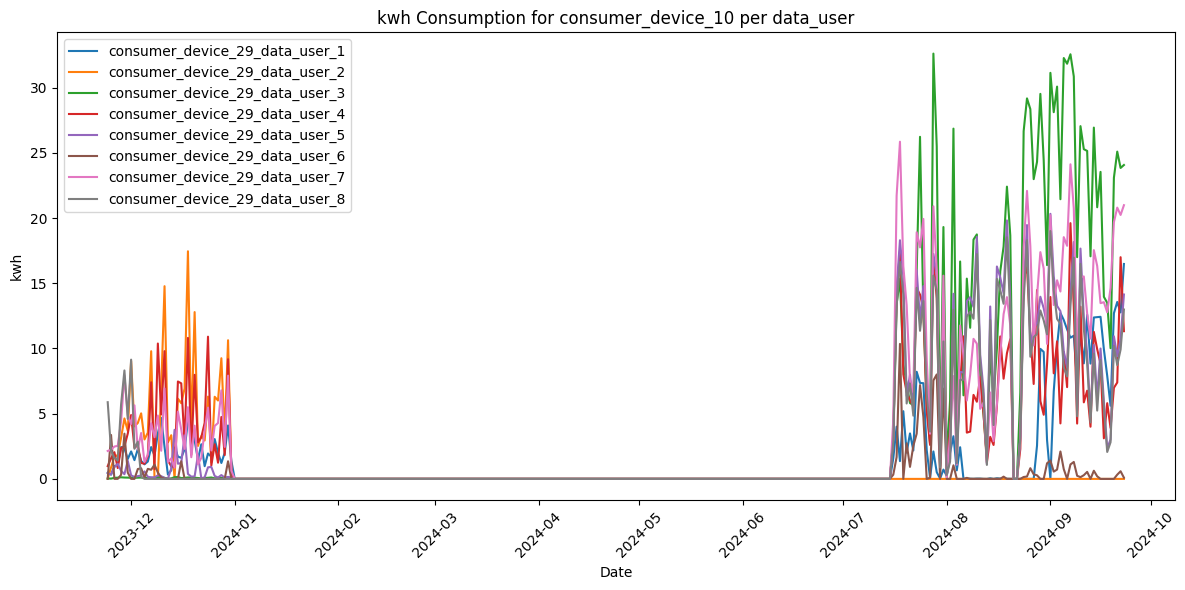

In [76]:
# Filter data for consumer_device_10
consumer_10_data = all_data_agg[all_data_agg['Source'].str.contains('consumer_device_29')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
